In [1]:
# package
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# import importlib; importlib.reload(pd)

In [2]:
# load data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
gender = pd.read_csv("./data/gender_submission.csv")
# train.info()
# 共891個index，沒有滿的就是空值
# train空值：Age, Cabin, Embarked
# test.info()
# 418
# test空值：Age, Fare, Cabin
data = train.append(test)

,Survived
Sex,
female,0.742
male,0.189


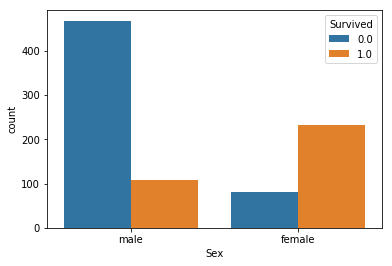

In [3]:
#查看資料_性別
sns.countplot(data['Sex'], hue=data['Survived'])
# plt.show()
# 生存人數:女>男

survived_sex = data[['Sex','Survived']].groupby(['Sex'], as_index=True).mean().round(3)
display(survived_sex)
# 生存比例：女=>0.742，男=>0.189

,Survived
Pclass,
1,0.630
2,0.473
3,0.242


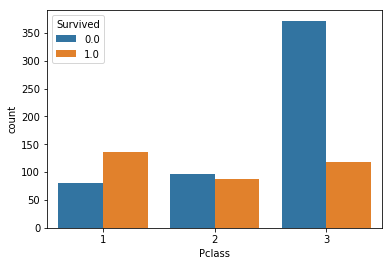

In [4]:
#查看資料_艙等
sns.countplot(data['Pclass'], hue=data['Survived'])
# plt.show()
# 生存人數:1>2>3

survived_pclass = data[['Pclass','Survived']].groupby(['Pclass'], as_index=True).mean().round(3)
display(survived_pclass)
# 生存比例：1=>0.63，2=>0.473，3=>0.242

In [5]:
# 把性別變成0/1編碼
data['Sex_code'] = data['Sex'].map({'female':int(1), 'male':int(0)})
train['Sex_code'] = train['Sex'].map({'female':int(1), 'male':int(0)})
test['Sex_code'] = test['Sex'].map({'female':int(1), 'male':int(0)})
# print(train.head())
data.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId',
       'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Sex_code'],
      dtype='object')

In [6]:
# x = train.drop(labels=['Survived','PassengerId'],axis=1)
x_train = train
y = train['Survived']
x_test = test

In [7]:
# CASE 1

# 特徵使用：性別
base = ['Sex_code']
# random_state：建樹資料的隨機性, n_estimators：樹數量, min_samples_split：節點資料數
base_model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
base_model.fit(x_train[base],y)
print('base oob score = {}'.format(base_model.oob_score_))
ans_1 = base_model.predict(x_test[base])
# display(ans_1)

# print(len(test.PassengerId))
# print(len(ans_1))
pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':ans_1}).set_index('PassengerId').to_csv('./result/sexcode.csv')

base oob score = 0.7867564534231201


In [8]:
# CASE 2

# 特徵使用：性別、艙等
base1 = ['Sex_code','Pclass']
base_model.fit(x_train[base1],y)
print('base oob score = {}'.format(base_model.oob_score_))
ans_2 = base_model.predict(x_test[base1])

if ans_1.all() == ans_2.all():
    print('預測結果 CASE1 = CASE2')

pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':ans_1}).set_index('PassengerId').to_csv('./result/sexcode_pclass.csv')

base oob score = 0.7317620650953984
預測結果 CASE1 = CASE2


max fare = 512.3292
min fare = 0.0
mean fare = 33.2954792813456
std fare = 51.75866823917414
median fare = 14.4542


Fare        
Survived    0.0     1.0
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

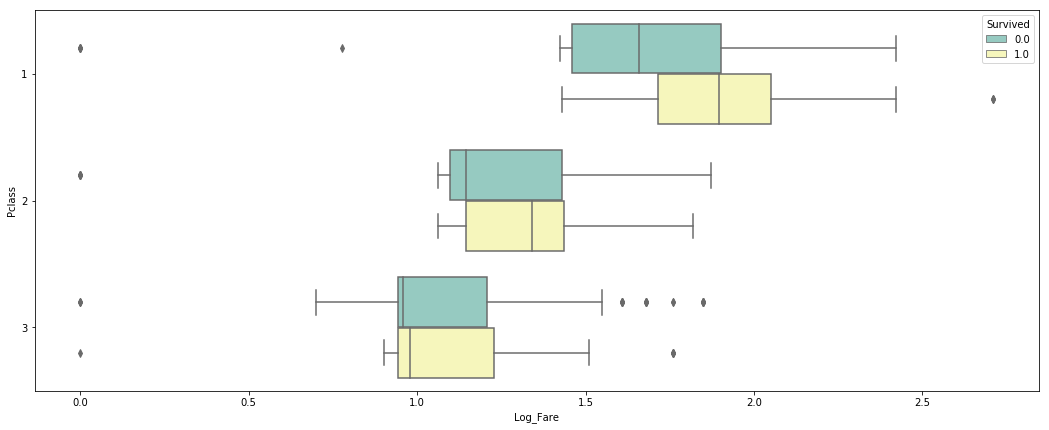

In [9]:
#查看資料_票價
print('max fare = {}'.format(data['Fare'].max()))
print('min fare = {}'.format(data['Fare'].min()))
print('mean fare = {}'.format(data['Fare'].mean()))
print('std fare = {}'.format(data['Fare'].std()))
print('median fare = {}'.format(data['Fare'].median()))


# sns.countplot(data['Fare'], hue=data['Survived'])
survived_fare = data[['Fare','Survived']].groupby(['Fare'], as_index=True).mean().round(3)
# display(survived_fare.head())

# 票價差異很大，取log解決
fig, ax = plt.subplots(figsize=(18,7))
data['Log_Fare'] = (data['Fare']+1).map(lambda x: np.log10(x))
# data['Log_Fare'].min()
sns.boxplot(y='Pclass', x='Log_Fare', hue='Survived', data=data, orient='h', ax=ax, palette='Set3' )
pd.pivot_table(data, values=['Fare'], index=['Pclass'], columns=['Survived'], aggfunc='median').round(3)

In [10]:
# Fare資料處理
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# 切分票價區間
# 區間太少：區間資料平均後無法看出差異
# 區間太多：資料差異放大，造成overfitting
# qcut：分位數
data['Fare_bin_4'] = pd.qcut(data['Fare'],4)
data['Fare_bin_5'] = pd.qcut(data['Fare'],5)
data['Fare_bin_6'] = pd.qcut(data['Fare'],6)
# display(data['Fare_bin_4'])
# display(data['Fare_bin_5'])

# LabelEncoder：把每個類別 mapping 到某個整數，不會增加新欄位
label = LabelEncoder()
data['Fare_Code_4'] = label.fit_transform(data['Fare_bin_4'])
data['Fare_Code_5'] = label.fit_transform(data['Fare_bin_5'])
data['Fare_Code_6'] = label.fit_transform(data['Fare_bin_6'])
display(data['Fare_Code_4'])

0      0
1      3
2      1
3      3
4      1
      ..
413    1
414    3
415    0
416    1
417    2
Name: Fare_Code_4, Length: 1309, dtype: int32

Pclass,1,2,3
Fare_bin_4,,,
"(-0.001, 7.896]",8,6,323
"(7.896, 14.454]",0,128,193
"(14.454, 31.275]",77,104,147
"(31.275, 512.329]",238,39,46
Pclass,1,2,3
Fare_bin_5,,,
"(-0.001, 7.854]",8,6,261
"(7.854, 10.5]",0,36,218
"(10.5, 21.558]",0,124,132


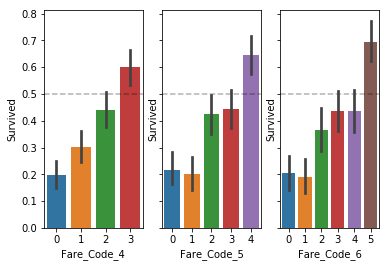

In [37]:

# cross tab
df_4 = pd.crosstab(data['Fare_bin_4'], data['Pclass'])
df_5 = pd.crosstab(data['Fare_bin_5'], data['Pclass'])
df_6 = pd.crosstab(data['Fare_bin_6'], data['Pclass'])

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
display_side_by_side(df_4,df_5,df_6)

# plot
fig, [ax1,ax2,ax3] = plt.subplots(1, 3, sharey=True)
# fig.set_figwidth(18)
for axi in [ax1,ax2,ax3]:
    axi.axhline(0.5,linestyle='dashed',c='black',alpha=0.3)
g1 = sns.factorplot(x='Fare_Code_4', y='Survived', data=data, kind='bar', ax=ax1)
g2 = sns.factorplot(x='Fare_Code_5', y='Survived', data=data, kind='bar', ax=ax2)
g3 = sns.factorplot(x='Fare_Code_6', y='Survived', data=data, kind='bar', ax=ax3)
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)

In [38]:
x_train = data[:len(train)]
y = x_train['Survived']
x_test = data[len(train):]
x_train = x_train.drop(labels=['Survived','PassengerId'],axis=1)
x_train.columns

# x_train['Sex_Code'] = x_train['Sex'].map({'female':int(1), 'male':int(0)})
# x_test['Sex_Code'] = x_test['Sex'].map({'female':int(1), 'male':int(0)})

# display(x_train.columns)
# display(x_test.columns)
# y = train.Survived
# display(y.head())

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Ticket', 'Sex_code', 'Log_Fare', 'Fare_bin_4', 'Fare_bin_5',
       'Fare_bin_6', 'Fare_Code_4', 'Fare_Code_5', 'Fare_Code_6'],
      dtype='object')

In [39]:
# 選擇切分特徵的區間數
compare = ['Sex_code', 'Pclass', 'Fare_Code_4', 'Fare_Code_5', 'Fare_Code_6']
# RFECV使用交叉驗證來選擇有最好準確率的訓練特徵數目。而交叉驗證也可以幫助我們避免訓練時造成過度訓練(overfitting)的現象
selector = RFECV(RandomForestClassifier(n_estimators=250, min_samples_split=20,), cv=10, n_jobs=-1)
selector.fit(x_train[compare], y)
# support：是否保留特徵，ranking：特徵重要程度排名
print(selector.support_)
print(selector.ranking_)
print(selector.grid_scores_)

# 6區間的準確率最好，但這裡沒有考慮到模型的random_state以及Cross-Validation切分的方式

[ True  True  True  True  True]
[1 1 1 1 1]
[0.78669816 0.77333986 0.79347747 0.79355295 0.80143088]


In [40]:
# 進行CV實驗

score_b4, score_b5, score_b6 = [], [], []
seeds=10
for i in range(seeds):
    
    # StratifiedKFold：K堆疊(Fold)的交叉驗證。將資料分為 K堆，一堆作為預測用，剩下的(K-1)堆則用來訓練，
    # 經過計算後，再以另外一堆作為預測，重複K次。
    diff_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
    
    # cv: 若無輸入，預設為3-fold的交叉驗證。輸入整數i，則做i-fold交叉驗證。若為物件，則以該物件做為交叉驗證產生器。
    selector = RFECV(RandomForestClassifier(random_state=i, n_estimators=250, min_samples_split=20,), cv=diff_cv, n_jobs=-1)
    selector.fit(x_train[compare], y)
    
    # gridscores: 從最有影響力的特徵開始加入，計算使用多少個特徵對應得到的準確率。
    score_b4.append(selector.grid_scores_[2])
    score_b5.append(selector.grid_scores_[3])
    score_b6.append(selector.grid_scores_[4])

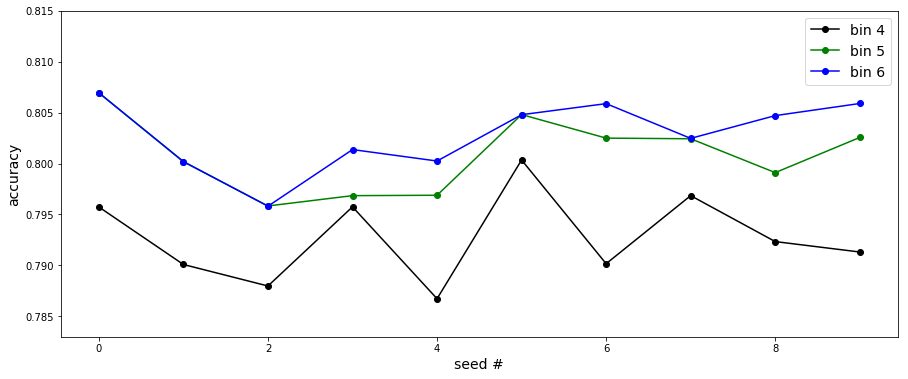

In [55]:
# np.array
score_list = [score_b4, score_b5, score_b6]
for item in score_list:
    item = np.array(item*100)

# print(len(score_b4))    
# print(len(score_b5))    

    
# 作圖看實驗結果
fig = plt.figure(figsize=(15,6))
ax = plt.gca()
ax.plot(range(seeds), score_b4, '-ok', label='bin 4')
ax.plot(range(seeds), score_b5, '-og', label='bin 5')
ax.plot(range(seeds), score_b6, '-ob', label='bin 6')

# display(ax)
ax.set_xlabel('seed #', fontsize='14')
ax.set_ylabel('accuracy', fontsize='14')
ax.set_ylim(0.783,0.815)
plt.legend(fontsize=14,loc='upper right')

In [42]:
# b6 > b5 > b4 (原使用性別、艙等的模型，另外再加入票價特徵)
b4 = ['Sex_code', 'Pclass', 'Fare_Code_4']
b5 = ['Sex_code', 'Pclass', 'Fare_Code_5']
b6 = ['Sex_code', 'Pclass', 'Fare_Code_6']

b4_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b4_Model.fit(x_train[b4], y)
ans_b4 = b4_Model.predict(x_test[b4])
print('b4 oob score = {}'.format(b4_Model.oob_score_.round(4)))

b5_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b5_Model.fit(x_train[b5], y)
ans_b5 = b5_Model.predict(x_test[b5])
print('b5 oob score = {}'.format(b5_Model.oob_score_.round(4)))

b6_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b6_Model.fit(x_train[b6], y)
ans_b6 = b6_Model.predict(x_test[b6])
print('b6 oob score = {}'.format(b6_Model.oob_score_.round(4)))

b4 oob score = 0.8058
b5 oob score = 0.8103
b6 oob score = 0.8013


In [43]:
# display(ans_1)
# display(f4)
# display(ans_b4)
# display(type(ans_b4))
# display(type(ans_1))
# display(type(ans_b4))
# a1 = pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':ans_1}).set_index('PassengerId')
# display(a1)

# 記得輸出要是整數(不然submit score=0)
ans_b4 = ans_b4.astype(int) 
ans_b5 = ans_b5.astype(int) 
ans_b6 = ans_b6.astype(int) 

pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':ans_b4}).set_index('PassengerId').to_csv('./result/sexcode_pclass_fareb4.csv')
pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':ans_b5}).set_index('PassengerId').to_csv('./result/sexcode_pclass_fareb5.csv')
pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':ans_b6}).set_index('PassengerId').to_csv('./result/sexcode_pclass_fareb6.csv')

In [44]:
# 票號(相同船票：家人(familysize>1)或朋友(familysize=1)，可能一起活或喪命)
x_train['Ticket'].describe()

# family size = sib + parch
data['Family_size'] = data['SibSp'] + data['Parch'] + 1

deplicate_ticket = []
for tk_no in data.Ticket.unique():
    # 票號和票價都相同     
    tmp = data.loc[data.Ticket==tk_no, 'Fare']
    if tmp.count() > 1:
        deplicate_ticket.append(data.loc[data.Ticket==tk_no,['Name','Age','Ticket', 'Fare', 'Cabin', 'Family_size', 'Survived']])
# display(pd.concat(deplicate_ticket))     
deplicate_ticket = pd.concat(deplicate_ticket)
deplicate_ticket.head(10)

print(len(deplicate_ticket))
# family
print(len(deplicate_ticket[deplicate_ticket.Family_size==1]))
# friend
print(len(deplicate_ticket[deplicate_ticket.Family_size>1]))

596
127
469


In [45]:
friend = deplicate_ticket.loc[(deplicate_ticket.Family_size==1) & (deplicate_ticket.Survived.notnull())]
family = deplicate_ticket.loc[(deplicate_ticket.Family_size>1) & (deplicate_ticket.Survived.notnull())]
# display(friend)
# display(family)
print('friends = {}'.format(len(friend)))
print('family = {}'.format(len(family)))

friends = 89
family = 321


In [46]:
# 建立新特徵(朋友和家人活下來的數量)
data['connect_survived'] = 0.5
# 同樣票號群組中，有人生還為1，無人生還為0
data_groupbytk = data.groupby('Ticket')
# data_groupbytk.agg({'Survived':'max'}).fillna(0.5)

# iterate over each group
for group_idx, group_data in data_groupbytk:
    # 有朋友or家人     
    if len(group_data) > 1:
        for row_idx, row in group_data.iterrows():
            # 除了自己以外的團體成員             
            others = group_data.drop(row_idx)
            fill_max = others['Survived'].max()
            #  fill_min = others['Survived'].min()
            passid = row['PassengerId']
            #  print('{} , {}'.format(fill_max, fill_min))
            #  print(row_idx)
            if fill_max == 1.0:
                data.loc[data['PassengerId']==passid, 'connect_survived'] = 1
                # data.loc[row_idx, 'connect_survived'] = 1
            elif fill_max == 0.0:
                data.loc[data['PassengerId']==passid, 'connect_survived'] = 0
                # data.loc[row_idx, 'connect_survived'] = 0
            # 如果nan算不出fill_max => 維持原本的0.5          dds
data['connect_survived'].describe()

count    1309.000000
mean        0.535141
std         0.305885
min         0.000000
25%         0.500000
50%         0.500000
75%         0.500000
max         1.000000
Name: connect_survived, dtype: float64

In [47]:
print(len(deplicate_ticket))
print(data[data['connect_survived']!=0.5].shape[0])
# 有同行人生還，自己生還的可能性也比較大
data.groupby('connect_survived')['Survived'].mean()

596
496


connect_survived
0.0    0.225352
0.5    0.297989
1.0    0.727723
Name: Survived, dtype: float64

In [48]:
# 有同行人生還，自己生還的可能性也比較大
data.groupby('connect_survived')['Survived'].mean()

connect_survived
0.0    0.225352
0.5    0.297989
1.0    0.727723
Name: Survived, dtype: float64

In [49]:
x_train = data[:len(train)]
x_test = data[len(train):]
y = x_train['Survived']
x_train = x_train.drop(labels=['Survived','PassengerId'],axis=1)
# x_train.columns

connect = ['Sex_code', 'Pclass', 'Fare_Code_5', 'connect_survived']

connect_model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
connect_model.fit(x_train[connect], y)
ans_connect = connect_model.predict(x_test[connect])
print('connect oob score = {}'.format(connect_model.oob_score_.round(4)))

ans_connect = ans_connect.astype(int) 
pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':ans_connect}).set_index('PassengerId').to_csv('./result/sexcode_pclass_fareb5_connect.csv')


connect oob score = 0.8204


Sex,female,male,All
has_age,,,
0,78,185,263
1,388,658,1046
All,466,843,1309


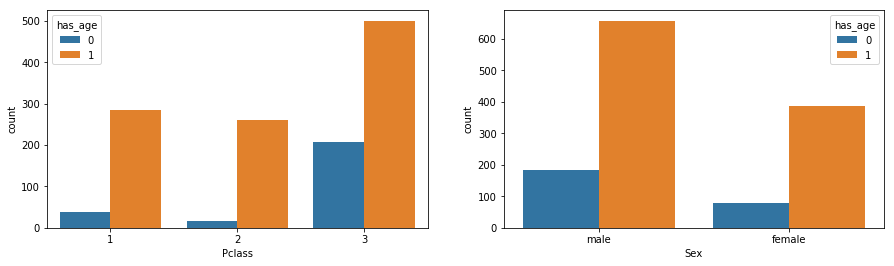

In [50]:
# 查看年齡資訊
data['has_age'] = data['Age'].isnull().map(lambda x: 0 if x==True  else 1 )
# display(data['has_age'])
fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_figwidth(15)
ax1 = sns.countplot(x=data['Pclass'], hue=data['has_age'],ax=ax1)
ax2 = sns.countplot(x=data['Sex'], hue=data['has_age'], ax=ax2)
pd.crosstab(data['has_age'], data['Sex'], margins=True)

# 第三艙沒有年齡數量多，可能數據預測失真
# 男性沒有年齡數量多，加入年齡可能預測更準(ex.男性小孩存活>男性成人存活)

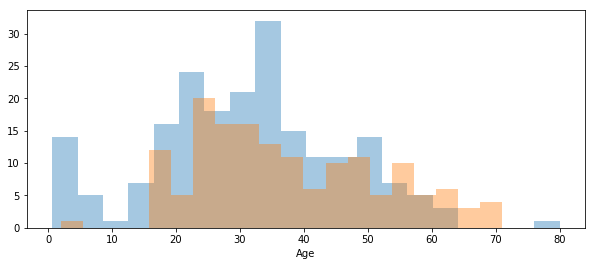

In [51]:
# 看存活和年齡間的關係
# 生存且非第三艙
hue_survived = data.loc[ ((data['Pclass']!=3) & (data['has_age']==1) & (data['Survived']==1)),'Age' ]
hue_dead = data.loc[ ((data['Pclass']!=3) & (data['has_age']==1) & (data['Survived']==0)),'Age' ]

# display(hue_survived)
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(10)
sns.distplot(hue_survived,kde=False,bins=20,ax=ax1)
sns.distplot(hue_dead,kde=False,bins=20,ax=ax1)

# 16歲以下年齡影響生存機率很大

In [52]:
data['title'] = data['Name'].str.extract(pat = '([A-Z][a-z]+)\.',expand=False)

title1 = ['Capt','Col','Countess','Don','Dr','Dona','Jonkheer','Major','Rev','Sir']
title2 = ['Mlle','Ms','Mme'] 
title3 = ['Lady']

data['title'] = data['title'].replace(title1,'Rare')
data['title'] = data['title'].replace(title2,'Miss')
data['title'] = data['title'].replace(title3,'Mrs')

# display(data['Title'])

title_dict = dict()
title_dict = {'Mr':0,'Mrs':1,'Miss':2,'Master':3,'Rare':4}
data['title_code'] = 0


for i in range(len(data['title'])):
    data['title_code'].iloc[i] = title_dict[data['title'].iloc[i]]
    
data.groupby('title')['Age'].median()

# display(data.title_code.head(20))
# display(data['Title'].unique())

title
Master     4.0
Miss      22.0
Mr        29.0
Mrs       36.0
Rare      47.0
Name: Age, dtype: float64

In [53]:
# 建立頭銜對應年齡中位數的dict
age_fill = dict()
key = list(data.groupby('title')['Age'].groups.keys())
value = data.groupby('title')['Age'].median().values
for i in range(len(key)):
    age_fill[key[i]] = value[i]
# display(age_fill)
    
# 保留原本的年齡特徵不動
data['title_age'] = data['Age']

for i in range(len(data)):
    if pd.isna(data.iloc[i]['Age']):
        title = data.iloc[i]['title']
        data['title_age'].iloc[i] = age_fill[title]
    
    
data['title_age'].describe()  
# display(data['title_age'].head(20))
data['title_age'] = data['title_age'].astype(int)
data['young'] = ((data['title_age'])<16)*1
# display(data['young'].head(20))

In [54]:
x_train = data[:len(train)]
x_test = data[len(train):]
y = x_train['Survived']
x_train = x_train.drop(labels=['Survived','PassengerId'],axis=1)

age = ['Sex_code', 'Pclass', 'Fare_Code_5', 'connect_survived', 'young']

age_model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
age_model.fit(x_train[age], y)
ans_age = age_model.predict(x_test[age])
print('age oob score = {}'.format(age_model.oob_score_.round(4)))

ans_age = ans_age.astype(int) 
pd.DataFrame({'PassengerId':test.PassengerId, 'Survived':ans_age}).set_index('PassengerId').to_csv('./result/sexcode_pclass_fareb5_connect_age.csv')




age oob score = 0.8418
